In [21]:
import sys
import os
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

import numpy as np
from models.VariationalAutoEncoder.VAE import VAE
from models.FaceVAE.FaceVAE import FaceVAE
from utils import face_simple_to_movie, plot_face, plot_anim_face, numpy_to_dataloader, combine_mouth_contour, separate_mouth_contour
from utils import lowpass

# データ準備

In [22]:
model_name = "VAE_Mouth.pth"
vae_mouth = VAE(input_dim=40, z_dim=3)
vae_mouth.load(model_name)

model_name = "VAE_Contour.pth"
vae_contour = VAE(input_dim=96, z_dim=3)
vae_contour.load(model_name)

model_name = "FaceVAE.pth"
face_vae = FaceVAE(vae_mouth, vae_contour)
face_vae.load(model_name)

In [23]:
npy_file_path = '../dataset/preprocessed_data_simple_8_fps.npy'
face_data = np.load(npy_file_path)
face_movie_data = face_simple_to_movie(face_data, 32)
# plot_anim_face(face_movie_data[0])

In [24]:
def encoder(data, face_vae):
    encoded_data = face_vae.encoder(data.reshape(-1, 136)).detach()
    encoded_data = encoded_data.reshape(-1, 32, 6)
    return encoded_data
def decoder(data, face_vae):
    decoded_data = data.reshape(-1, 32, 6).reshape(-1, 6)
    decoded_data = face_vae.decoder(decoded_data).detach()
    decoded_data = decoded_data.reshape(-1, 32, 136)
    return decoded_data

In [25]:
raw_data = torch.from_numpy(face_movie_data)
raw_data = encoder(raw_data, face_vae)
raw_data = raw_data.unsqueeze(1)

# VAEAC

In [26]:
import sys
sys.path.append('../vaeac')

from argparse import ArgumentParser
from copy import deepcopy
from importlib import import_module
from math import ceil
from os.path import exists, join
from sys import stderr

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from datasets import compute_normalization
from imputation_networks import get_imputation_networks
from train_utils import extend_batch, get_validation_iwae
from VAEAC import VAEAC

import warnings
warnings.simplefilter('ignore')

In [27]:
class args:
    epochs = 500
    validation_ratio = 0.1
    validation_iwae_num_samples = 25
    validations_per_epoch = 1
    use_last_checkpoint = False
    train = False
    chekpoint = 'face_vaeac_batch_8_test_conv.pth'

In [28]:
# preprocess
data = (raw_data - 0) / 1

In [29]:
use_cuda = torch.cuda.is_available()
num_workers = 0

In [30]:
model_module = import_module('facevideo_model.model')

In [31]:
# model
model = VAEAC(
    model_module.reconstruction_log_prob,
    model_module.proposal_network,
    model_module.prior_network,
    model_module.generative_network
)
if use_cuda:
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=2e-4)# model_module.optimizer(model.parameters())
scheduler = ExponentialLR(optimizer, gamma=0.999)
batch_size = model_module.batch_size
mask_generator = model_module.mask_generator
vlb_scale_factor = getattr(model_module, 'vlb_scale_factor', 1)

In [32]:
# dataset
val_size = ceil(len(data) * args.validation_ratio)
val_indices = np.random.choice(len(data), val_size, False)
val_indices_set = set(val_indices)
train_indices = [i for i in range(len(data)) if i not in val_indices_set]
train_data = data[train_indices]
val_data = data[val_indices]

In [33]:
# dataloader
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True,
                        num_workers=num_workers, drop_last=False)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True,
                            num_workers=num_workers, drop_last=False)

In [34]:
validation_iwae = []
train_vlb = []
best_state = None

In [35]:
def train(verbose=True):
    bar = tqdm(range(args.epochs))
    for epoch in bar:
        iterator = dataloader
        avg_vlb = 0
        if verbose:
            bar.set_description('[Epoch %d]' % (epoch + 1))
            iterator = tqdm(iterator, leave=False, desc='Train')
        # one epoch
        # train
        for i, batch in enumerate(iterator):
            # if batch size is less than batch_size, extend it with objects
            # from the beginning of the dataset
            batch = extend_batch(batch, dataloader, batch_size)

            # generate mask and do an optimizer step over the mask and the batch
            mask = mask_generator(batch)
            optimizer.zero_grad()
            if use_cuda:
                batch = batch.cuda()
                mask = mask.cuda()
            vlb = model.batch_vlb(batch, mask).mean()
            (-vlb / vlb_scale_factor).backward()
            optimizer.step()

            # update running variational lower bound average
            avg_vlb += (float(vlb) - avg_vlb) / (i + 1)
            if verbose:
                iterator.set_postfix({"Train VLB": '%g' % avg_vlb})
                
        scheduler.step()
        # validation
        val_iwae = get_validation_iwae(val_dataloader, mask_generator,
                                       batch_size, model,
                                       args.validation_iwae_num_samples,
                                       True)
        validation_iwae.append(val_iwae)
        train_vlb.append(avg_vlb)

        # if current model validation IWAE is the best validation IWAE
        # over the history of training, the current state
        # is saved to best_state variable
        if max(validation_iwae[::-1]) <= val_iwae:
            best_state = deepcopy({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'validation_iwae': validation_iwae,
                'train_vlb': train_vlb,
            })
            torch.save(best_state, args.chekpoint)

In [36]:
if args.train:
    train()
    
best_state = torch.load(args.chekpoint)
model.load_state_dict(best_state['model_state_dict'])

<All keys matched successfully>

# 欠損値予測

In [32]:
def get_samples(batch, K=10):
    if use_cuda:
        batch = batch.cuda()

    # compute the imputation mask
    mask = torch.isnan(batch).float()

    # compute imputation distributions parameters
    with torch.no_grad():
        samples_params = model.generate_samples_params(batch,
                                                       mask,
                                                       K)

    # make a copy of batch with zeroed missing values
    mask = torch.isnan(batch)
    batch_zeroed_nans = torch.tensor(batch)
    batch_zeroed_nans[mask] = 0

    # impute samples from the generative distributions into the data
    # and save it to the results
    results = []
    for i in range(K):
        results.append([])
    for i in range(K):
        sample_params = samples_params[:, i]
        sample = model_module.sampler(sample_params)
        sample[~mask] = 0
        sample += batch_zeroed_nans
        results[i].append(torch.tensor(sample, device='cpu'))

    for i in range(len(results)):
        results[i] = torch.cat(results[i]).unsqueeze(1)
    result = torch.cat(results, 1)

    return result

## 8フレーム置きにランダムな顔を指定

In [28]:
z_faces = torch.randn(4, 6)

In [29]:
data = torch.full((32,6), float('nan'))
data[::8] = z_faces
batch = data.unsqueeze(0).unsqueeze(0).cuda()
mask = torch.isnan(batch).cuda()

In [34]:
results = get_samples(batch, 4)
results = decoder(results, face_vae)

# 生成データ
plot_anim_face(results[0])

Text(0.5, 0.98, 'FaceVAEAC output')

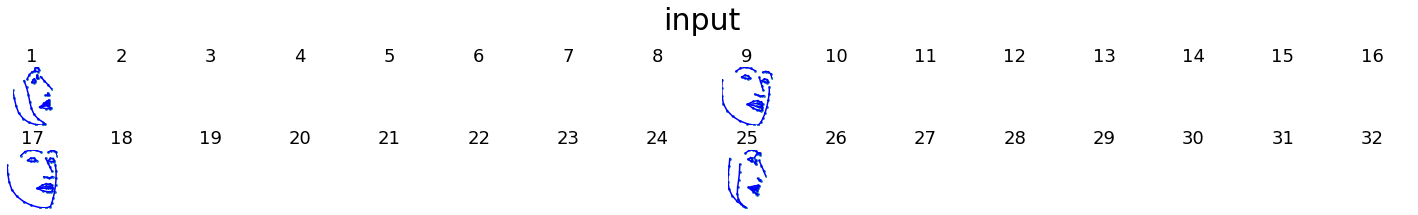

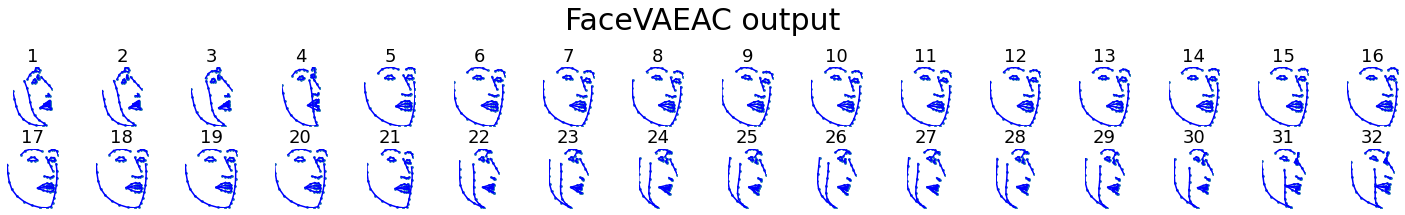

In [35]:
data = face_movie_data[10]
fig, axis = plt.subplots(2, 16, figsize=(20, 3))
axis = axis.ravel()
cnt = 0
for i, ax in enumerate(axis):
    ax.axis("off")
    ax.set_title(f"{i+1}", fontsize=18)
    # plot_face(output[i], ax)
    if i%8 == 0:
        # plot_face(data[i], ax)
        plot_face(face_vae.decoder(z_faces[cnt].unsqueeze(0)).detach()[0], ax)
        cnt += 1

plt.tight_layout()
plt.subplots_adjust(top=0.7)
fig.suptitle('input', fontsize=30)

fig, axis = plt.subplots(2, 16, figsize=(20, 3))
axis = axis.ravel()
for i, ax in enumerate(axis):
    ax.axis("off")
    ax.set_title(f"{i+1}", fontsize=18)
    plot_face(results[0][i], ax)
    
plt.tight_layout()
plt.subplots_adjust(top=0.7)
fig.suptitle('FaceVAEAC output', fontsize=30)

# model & Mask 実験用

In [23]:
from torch import nn
from torch.optim import Adam

from mask_generators import ImageMaskGenerator, ImageMCARGenerator
from nn_utils import ResBlock, MemoryLayer, SkipConnection
from prob_utils import normal_parse_params, GaussianLoss


In [24]:
class ImageFaceMaskGenerator:
    """
    Samples mask from component-wise independent Bernoulli distribution
    with probability of _pixel_ to be unobserved p.
    """
    def __init__(self, p):
        self.p = p

    def __call__(self, batch):
        nan_mask = torch.isnan(batch).float()  # missed values
        bernoulli_mask_numpy = np.random.choice(2, size=(batch.shape[0], 1, 32, 1),
                                                p=[1 - self.p, self.p])
        bernoulli_mask_numpy = np.tile(bernoulli_mask_numpy,6)
        bernoulli_mask = torch.from_numpy(bernoulli_mask_numpy).float()
        mask = torch.max(bernoulli_mask, nan_mask)  # logical or
        return mask

In [25]:
batch = iter(dataloader).__next__()
mask = ImageFaceMaskGenerator(.8)(batch)

input = torch.cat([batch, mask], 1)
input.shape

torch.Size([16, 2, 32, 6])

In [390]:
def MLPBlock(dim):
    return SkipConnection(
        nn.BatchNorm2d(dim),
        nn.LeakyReLU(),
        nn.Conv2d(dim, dim, 1)
    )

proposal_network = nn.Sequential(
    nn.Conv2d(2, 8, 1),
    ResBlock(8, 8), ResBlock(8, 8), ResBlock(8, 8), ResBlock(8, 8),
    nn.Conv2d(8, 16, 1), nn.Conv2d(16, 32, 1),
    ResBlock(32, 16), ResBlock(32, 16), ResBlock(32, 16), ResBlock(32, 16),
    nn.Conv2d(32, 64, 1),
    ResBlock(64, 32), ResBlock(64, 32), ResBlock(64, 32), ResBlock(64, 32),
    nn.Conv2d(64, 128, 1),
    ResBlock(128, 64), ResBlock(128, 64),
    ResBlock(128, 64), ResBlock(128, 64),
    nn.AvgPool2d(2, 2), nn.Conv2d(128, 256, 1),
    ResBlock(256, 128), ResBlock(256, 128),
    ResBlock(256, 128), ResBlock(256, 128),
    nn.AvgPool2d(2, 2), nn.Conv2d(256, 512, 1),
    MLPBlock(512), MLPBlock(512), MLPBlock(512), MLPBlock(512),
)

prior_network = nn.Sequential(
    MemoryLayer('#0'),
    nn.Conv2d(2, 8, 1),
    ResBlock(8, 8), ResBlock(8, 8), ResBlock(8, 8), ResBlock(8, 8),
    MemoryLayer('#1'),
    nn.Conv2d(8, 16, 1), nn.Conv2d(16, 32, 1),
    ResBlock(32, 16), ResBlock(32, 16), ResBlock(32, 16), ResBlock(32, 16),
    MemoryLayer('#2'),
    nn.Conv2d(32, 64, 1),
    ResBlock(64, 32), ResBlock(64, 32), ResBlock(64, 32), ResBlock(64, 32),
    MemoryLayer('#3'),
    nn.Conv2d(64, 128, 1),
    ResBlock(128, 64), ResBlock(128, 64), ResBlock(128, 64), ResBlock(128, 64),
    MemoryLayer('#4'),
    nn.AvgPool2d(2, 2), nn.Conv2d(128, 256, 1),
    ResBlock(256, 128), ResBlock(256, 128), ResBlock(256, 128), ResBlock(256, 128),
    MemoryLayer('#5'),
    nn.AvgPool2d(2, 2), nn.Conv2d(256, 512, 1),
    MLPBlock(512), MLPBlock(512), MLPBlock(512), MLPBlock(512),
)

generative_network = nn.Sequential(
    nn.Conv2d(256, 256, 1),
    MLPBlock(256), MLPBlock(256), MLPBlock(256), MLPBlock(256),
    nn.Conv2d(256, 128, 1), nn.Upsample(scale_factor=2),nn.Conv2d(128, 128, (1, 2), 1, padding=(0, 1)), 
    MemoryLayer('#5', True), nn.Conv2d(384, 128, 1),
    ResBlock(128, 64), ResBlock(128, 64), ResBlock(128, 64), ResBlock(128, 64),
    nn.Conv2d(128, 64, 1), nn.Upsample(scale_factor=2),
    MemoryLayer('#4', True), nn.Conv2d(192, 64, 1),
    ResBlock(64, 32), ResBlock(64, 32), ResBlock(64, 32), ResBlock(64, 32),
    nn.Conv2d(64, 32, 1), 
    MemoryLayer('#3', True), nn.Conv2d(96, 32, 1),
    ResBlock(32, 16), ResBlock(32, 16), ResBlock(32, 16), ResBlock(32, 16),
    nn.Conv2d(32, 64, 1), 
    MemoryLayer('#2', True), nn.Conv2d(96, 64, 1),
    nn.Conv2d(64, 32, 1),
    ResBlock(32, 16), ResBlock(32, 16), ResBlock(32, 16), ResBlock(32, 16),
    nn.Conv2d(32, 16, 1), nn.Conv2d(16, 8, 1),
    MemoryLayer('#1', True), nn.Conv2d(16, 8, 1),
    ResBlock(8, 8), ResBlock(8, 8), ResBlock(8, 8), ResBlock(8, 8),
    MemoryLayer('#0', True), 
    nn.Conv2d(10, 1, 1),
)